Execution for house price estimation

In [1]:
# Import relevant files and libraries
import DataProcessor
import sys
import LRegression
import NLRegression
import performance_metrics
import Kmeans
import UserInterface
import numpy as np
import pandas as pd

Define the parameters



In [2]:
# Allocate 80% of data to training
train_size = 0.7

# Identify features to be used
columnsToKeep = ['Price','Type','Bedroom','Bathroom','Car','Landsize', 'BuildingArea', 'Latitude','Longitude']

# Path to dataset.
filepath = '../dataset/Melbourne_housing_FULL.csv'

# Identify prediction (ground truth)
prediction_column = 'Price'

Process raw data

Data Processor object created
Number of rows removed: 5741
Number of rows remaining: 2034


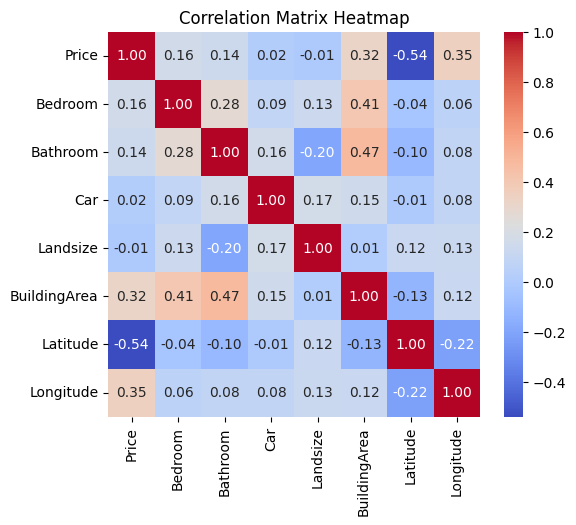

training size 700
test size 300


In [3]:
# Create a DataProcessor object and load the data
dp_obj = DataProcessor.DataProcessor()
dp_obj.LoadData(filepath)

# Remove incomplete points, remove unused features and shuffle the data
dp_obj.keepSelectedColumns(columnsToKeep)
dp_obj.filterMelbourneData()

dp_obj.remove_outliers(columnsToKeep, plot=False)

# dp_obj.encodeCategoricalData(['Type'])
dp_obj.shuffleData()
dp_obj.reduceDataSize(1000) # remove this to train on the full dataset


columnsToCorrelate = ['Price','Bedroom','Bathroom','Car','Landsize', 'BuildingArea', 'Latitude','Longitude']
dp_obj.calculateCorelation(columnsToCorrelate)

# Split the data into training and testing
train_X, train_Y, test_X, test_Y = dp_obj.splitData(train_size, prediction_column)

# print(train_X.head())

# Remove dwelling type and additional landsize / building area data for some processing
clean_columns = ['Type', 'Landsize']
train_X_clean = train_X.drop(columns=clean_columns,axis=1)
test_X_clean = test_X.drop(columns=clean_columns,axis=1)

K-Means Clustering

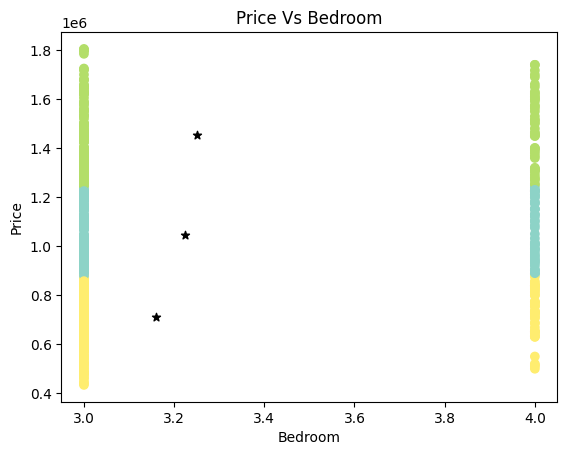

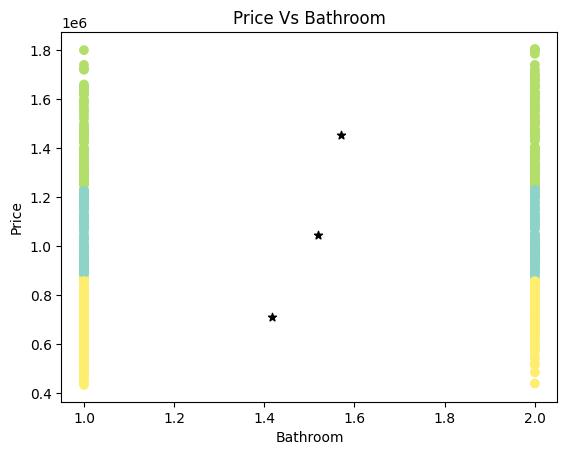

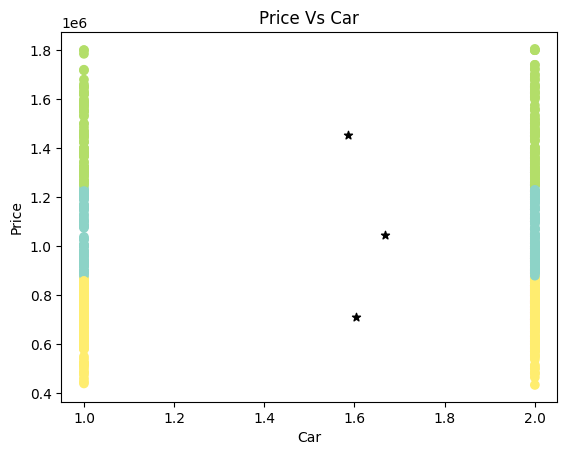

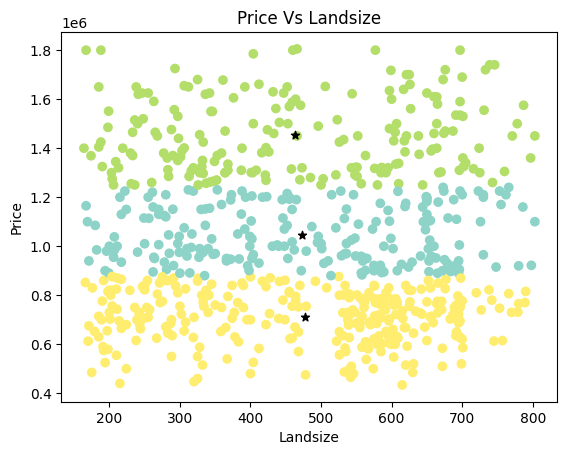

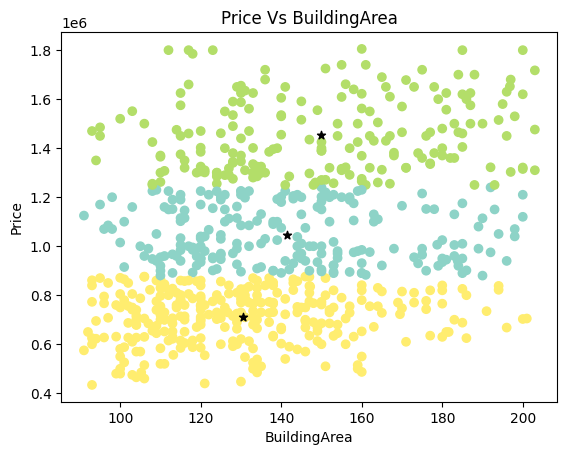

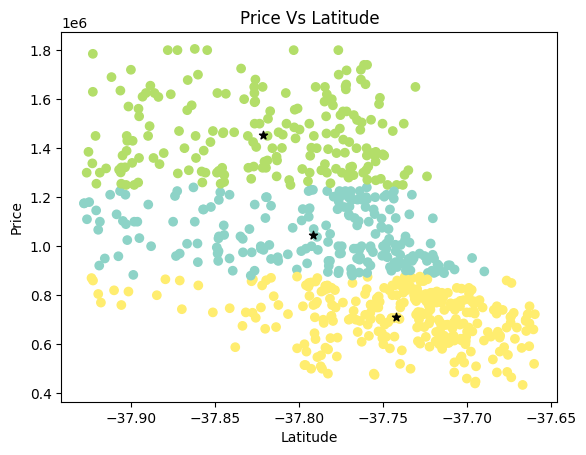

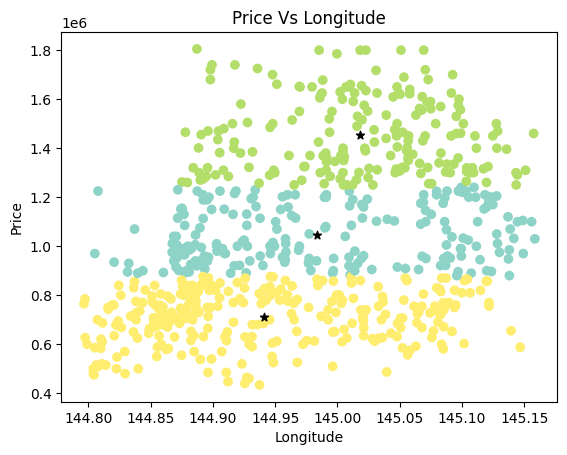

train_X columns
Index(['Type', 'Bedroom', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'Latitude', 'Longitude', 'Size', 'AssignmentBedroom',
       'AssignmentBathroom', 'AssignmentCar', 'AssignmentLandsize',
       'AssignmentBuildingArea', 'AssignmentLatitude', 'AssignmentLongitude'],
      dtype='object')
test_X columns
Index(['Type', 'Bedroom', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'Latitude', 'Longitude', 'Size', 'AssignmentBedroom',
       'AssignmentBathroom', 'AssignmentCar', 'AssignmentLandsize',
       'AssignmentBuildingArea', 'AssignmentLatitude', 'AssignmentLongitude'],
      dtype='object')


In [4]:
# Ashton
k = 3
prefs = ['Bedroom','Bathroom','Car','Landsize', 'BuildingArea', 'Latitude','Longitude']

all_points = []
all_centroids = []

for pref in prefs:
    kmeansTrain = Kmeans.Kmeans(train_X, train_Y, k, pref)

    train_X, points, centroids = kmeansTrain.cluster()

    all_points.append(points)
    all_centroids.append(centroids)
    
    # Plot the data
    kmeansTrain.plotKmean(train_X, points, centroids, pref)

for pref in prefs:
    kmeansTest = Kmeans.Kmeans(test_X, test_Y, k, pref)

    test_X, points, centroids = kmeansTest.cluster()

    all_points.append(points)
    all_centroids.append(centroids)

    # Plot the data
    # kmeansTest.plotKmean(test_X, points, centroids, pref)

# kmeans = Kmeans.Kmeans(train_X, train_Y, k, prefs)

# train_X, points, centroids = kmeans.cluster()

# all_points.append(points)
# all_centroids.append(centroids)

# kmeans.plotKmean(train_X, points, centroids, prefs)

print('train_X columns')
print(train_X.columns)

print('test_X columns')
print(test_X.columns)

Linear Regression

In [5]:
# Train
lr = LRegression.LRegression()
values = ['Bedroom','Bathroom','Car','Landsize','BuildingArea','Latitude','Longitude']
assignments = ['AssignmentBedroom','AssignmentBathroom','AssignmentCar','AssignmentLandsize','AssignmentBuildingArea','AssignmentLatitude','AssignmentLongitude']

# Initialise weights
w = []

# Initialise MSE
train_mse = []

# Calculate weights for houses
for i in range(k):
    weight = lr.LinReg(train_X,train_Y,values,assignments,i)
    w.append(weight)
w = np.array(w)
w = w.reshape(w.shape[0],w.shape[1],-1)

# Calculate MSE for houses
for i in range(k):
    train_mse.append(lr.MSE(train_X[values],w[i,:],train_Y))
print("Training error (houses) = ", train_mse)

Training error (houses) =  [35000858256007.188, 73563318955663.64, 14795829162530.434]


In [6]:
# Test

# Initialise MSE
test_mse = []

# Calculate MSE for houses
for i in range(k):
    test_mse.append(lr.MSE(test_X[values],w[i,:],test_Y))
print("Testing error (houses) = ", test_mse)

Testing error (houses) =  [35739771590719.516, 74921001906319.84, 15174687973226.746]


Non-Linear Regression (Gaussian Processing)

In [ ]:
# # creating interaction features based on the assigned cluster

# assignments = ['AssignmentBedroom','AssignmentBathroom','AssignmentCar','AssignmentLandsize','AssignmentLatitude','AssignmentLongitude']
# features = ['Bedroom','Bathroom','Car','Landsize', 'Latitude','Longitude']

# # get the average assignment value for each house (row)
# train_X['AverageAssignment'] = train_X[assignments].mean(axis=1)
# test_X['AverageAssignment'] = test_X[assignments].mean(axis=1)


# train_X['Bedroom'] = train_X['Bedroom'] * train_X['AssignmentBedroom']
# train_X['Bathroom'] = train_X['Bathroom'] * train_X['AssignmentBathroom']
# train_X['Car'] = train_X['Car'] * train_X['AssignmentCar']
# train_X['Landsize'] = train_X['Landsize'] * train_X['AssignmentLandsize']
# train_X['BuildingArea'] = train_X['BuildingArea'] * train_X['AssignmentLandsize']
# train_X['Latitude'] = train_X['Latitude'] * train_X['AssignmentLatitude']
# train_X['Longitude'] = train_X['Longitude'] * train_X['AssignmentLongitude']

# test_X['Bedroom'] = test_X['Bedroom'] * test_X['AssignmentBedroom']
# test_X['Bathroom'] = test_X['Bathroom'] * test_X['AssignmentBathroom']
# test_X['Car'] = test_X['Car'] * test_X['AssignmentCar']
# test_X['Landsize'] = test_X['Landsize'] * test_X['AssignmentLandsize']
# test_X['BuildingArea'] = test_X['BuildingArea'] * test_X['AssignmentLandsize']
# test_X['Latitude'] = test_X['Latitude'] * test_X['AssignmentLatitude']
# test_X['Longitude'] = test_X['Longitude'] * test_X['AssignmentLongitude']



# multiple everything some scale. This is for testing purposes
# scale = 2

# train_X['Bedroom'] = train_X['Bedroom'] * scale
# train_X['Bathroom'] = train_X['Bathroom'] * scale
# train_X['Car'] = train_X['Car'] * scale
# train_X['Landsize'] = train_X['Landsize'] * scale
# train_X['BuildingArea'] = train_X['BuildingArea'] * scale
# train_X['Latitude'] = train_X['Latitude'] * scale
# train_X['Longitude'] = train_X['Longitude'] * scale

# test_X['Bedroom'] = test_X['Bedroom'] * scale
# test_X['Bathroom'] = test_X['Bathroom'] * scale
# test_X['Car'] = test_X['Car'] * scale
# test_X['Landsize'] = test_X['Landsize'] * scale
# test_X['BuildingArea'] = test_X['BuildingArea'] * scale
# test_X['Latitude'] = test_X['Latitude'] * scale
# test_X['Longitude'] = test_X['Longitude'] * scale

# print(train_X.head())
# print(test_X.head())



In [ ]:
# Train

# must be ordered by correlation to price (highest to lowest)
featuresToTrain = ['Latitude', 'BuildingArea', 'Landsize', 'Longitude'] # ['Size','Latitude', 'AssignmentLatitude' ,'Longitude', 'AssignmentLongitude']

# ask to train or load a model
query = input("Do you want to train a new model? (y/n): ")
if query == 'y':
    # Ask user for features to train on
    nlr = NLRegression.NLRegression(train_X, train_Y, test_X, test_Y, featuresToTrain)
    nlr.train()
    # ask to save
    query = input("Do you want to save the model? (y/n): ")
    if query == 'y':
        _, _, r_2 = nlr.evaluate()
        filepath_ = '../saved_models/nlr_model_R_2_' + str(r_2)
        nlr.saveModel(filepath_)
else:
    nlr = NLRegression.NLRegression(train_X, train_Y, test_X, test_Y, featuresToTrain)
    filename_ = input("Enter the filename of the model to load: ")
    filepath_ = '../saved_models/' + filename_
    nlr.loadModel(filepath_)

# plotting predictions vs expected
nlr.plot()

In [ ]:
# slow but more accurate test
nlr.cross_validate()

In [ ]:
# Select a sample row and keep it as a Series
sample_number = 30

sample = test_X[featuresToTrain].iloc[sample_number]
print("sample: ", sample.values)

# Predict using the model with the scaled data
pred, bounds = nlr.predictActual(sample)
print("prediction: ", pred[0])
# print("bounds:     ", bounds[0], bounds[1])
print("actual:     ", test_Y.iloc[sample_number])

Evaluation Metrics

In [ ]:
from performance_metrics import ElbowMethod
from DataProcessor import DataProcessor
import pandas as pd
from sklearn.impute import SimpleImputer

# Identify features to be used (excluding 'Type')
columnsToKeep = ['Price', 'Bedroom', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Latitude', 'Longitude']

# Path to dataset
filepath = '../dataset/Melbourne_housing_FULL.csv'

# Step 1: Load and preprocess the data
data_processor = DataProcessor()
data = data_processor.LoadData(filepath)

# Drop columns that are not relevant or cannot be converted to numeric
data = data_processor.keepSelectedColumns(columnsToKeep)

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Step 2: Use the ElbowMethod class with the preprocessed data
elbow_method = ElbowMethod(data)  # Initialize ElbowMethod
elbow_method.evaluate(max_clusters=10)
elbow_method.plot()
optimal_clusters = elbow_method.optimal_number_of_clusters()
print("Optimal number of clusters:", optimal_clusters)


In [ ]:
# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from Kmeans import Kmeans
from performance_metrics import ElbowMethod

# Load and preprocess the data
data_processor = DataProcessor()
data = data_processor.LoadData(filepath)
data = data_processor.keepSelectedColumns(columnsToKeep)
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Elbow Method for Optimal K
elbow_method = ElbowMethod(data_scaled)
elbow_method.evaluate(max_clusters=10)
elbow_method.plot()
optimal_clusters = elbow_method.optimal_number_of_clusters()
print("Optimal number of clusters:", optimal_clusters)
print(train_X.columns)
print(train_X)


In [ ]:
from performance_metrics import calculate_silhouette_score

# Assuming kmeans.cluster() returns x_new, points, centroids
kmeans_instance = Kmeans(train_X, train_Y, optimal_clusters, pref)
x_new, points, centroids = kmeans_instance.cluster()
assignment = x_new['Assignment' + pref].values  # Extract the cluster assignments

silhouette_avg = calculate_silhouette_score(points, assignment)
print("Silhouette Score:", silhouette_avg)

In [ ]:
from sklearn.metrics import silhouette_score

# Assuming kmeans.cluster() returns x_new, points, centroids
kmeans_instance = Kmeans(train_X, train_Y, optimal_clusters, pref)
x_new, points, centroids = kmeans_instance.cluster()
assignment = x_new['Assignment' + pref].values  # Extract the cluster assignments

silhouette_avg = silhouette_score(points, assignment)
print("Silhouette Score:", silhouette_avg)


User input for preference

In [7]:
# Calculate mean values if no user preference is provided
meanLand = dp_obj.getAverage('Landsize')
meanBuilding = dp_obj.getAverage('BuildingArea')

# Input user preferences
user_pref = UserInterface.UserInterface()
bedrooms, bathrooms, car, landsize, buildingarea, latitude, longitude = user_pref.Inputs(meanLand, meanBuilding)
print("Bedrooms = ",bedrooms," Bathrooms = ",bathrooms," Car parks = ",car," Land size = ",landsize," Building area = ",buildingarea," Latitude = ",latitude," Longitude = ",longitude)

Bedrooms =  3.0  Bathrooms =  2.0  Car parks =  1.0  Land size =  478.29  Building area =  138.5480751  Latitude =  -37.5903  Longitude =  144.6994


Final prediction

In [10]:
# Return predicted value from Linear Regression

# Assign feature inputs
targets = [bedrooms,bathrooms,car,landsize,buildingarea,latitude,longitude]

# Make prediction for each level
pred = lr.predict(targets,w)

# Return minimum value
print("Minimum value = $",np.min(pred))

# Return maximum value
print("Maximum value = $",np.max(pred))

Minimum value = $ 679790.2372818515
Maximum value = $ 1337999.7664013884


In [ ]:
# featuresToTrain = ['Latitude', 'BuildingArea', 'Landsize', 'Longitude'] # ['Size','Latitude', 'AssignmentLatitude' ,'Longitude', 'AssignmentLongitude']


sample = pd.Series([latitude, 136, 408, longitude], index=featuresToTrain)
pred, bounds = nlr.predictActual(sample)
print("prediction: ", pred[0])
# print("bounds:     ", bounds[0], bounds[1])